In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statistics import mean
import gc


from sklearn.preprocessing import StandardScaler,OneHotEncoder

import os
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, CuDNNLSTM, Flatten
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.callbacks import History

In [10]:
train_data = pd.read_csv('../input/train.csv',dtype = {'acoustic_data':np.float32,'time_to_failure':np.float32})




In [15]:
rows = 150000
segments = int(np.floor(train_data.shape[0] / rows))

X_train = np.zeros((segments,150000))
y_train = pd.DataFrame(index = range(segments),dtype = np.float32,columns = ['time_to_failure'])

for segment in tqdm(range(segments)):
    x = train_data.iloc[segment*rows:segment*rows+rows]
    y = x['time_to_failure'].values[-1]
    x = x['acoustic_data'].values
    y_train.loc[segment,'time_to_failure'] = y
    X_train[segment] = x
del train_data

100%|██████████| 4194/4194 [00:04<00:00, 864.75it/s]


In [29]:
gc.collect()

252

In [19]:
X_train.shape
y_train['time_to_failure'] = round(y_train['time_to_failure'])

In [22]:
y_train['time_to_failure'] = y_train['time_to_failure'].astype(np.int32)

In [28]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train['time_to_failure']).reshape(-1,1))

In [32]:
y_train.shape

(4194, 17)

In [35]:
model = Sequential()
model.add(Conv1D(filters=40, kernel_size=20, strides=2, activation='relu', input_shape=(150000,1)))
model.add(MaxPooling1D(3))
model.add(Conv1D(filters=40, kernel_size=20, strides=1, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(filters=40, kernel_size=20, strides=1, activation='relu'))
model.add(MaxPooling1D(3))
model.add(CuDNNLSTM(8,return_sequences=True))
model.add(CuDNNLSTM(8,return_sequences=True))
#model.add(Flatten())
model.add(Conv1D(filters=40, kernel_size=10, strides=1, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(rate=0.1))
model.add(Dense(17,activation = 'softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 74991, 40)         840       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24997, 40)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24978, 40)         32040     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 8326, 40)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8307, 40)          32040     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2769, 40)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 2769, 8)           1600      
__________

In [36]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
model.fit(X_train.reshape(-1,150000,1),y_train,epochs = 100, validation_split = 0.1,batch_size = 16)

Train on 3774 samples, validate on 420 samples
Epoch 1/100
3774/3774 [==============================] - 50s 13ms/step - loss: 2.6606 - val_loss: 2.5530
Epoch 2/100
1312/3774 [=========>....................] - ETA: 30s - loss: 2.6503

def prepareAd(x):
    x = np.sign(x)*np.log(1 + np.sqrt(np.abs(x)))/4.4
    return x

def getTrainBatch(dfl,nrows,batch_size):
    x = np.empty([batch_size,15000,1])
    y = np.empty([batch_size,15000])
    for i,rn in enumerate(np.random.randint(nrows-15000, size=batch_size)):
        df = dfl.loc[rn:rn+14999,:]
        x[i,:,0] = df.acoustic_data.values
        y[i,:] = df.time_to_failure.values
    return x,y

random.seed(42)
history = History()
step = 150000000
stop = 600000000
#sc = StandardScaler()
for i in range(0, stop, step):
    print('Reading file chunk :',i)
    train_df = pd.read_csv("../input/train.csv",
                           skiprows = i,
                           nrows = step,
                           dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}
                          )
    train_df.columns = ['acoustic_data','time_to_failure']
    #train_df.acoustic_data =prepareAd(train_df.acoustic_data.values)
    #train_df.time_to_failure = train_df.time_to_failure/16
    
    loss = []
    val_loss = []
    mae = []
    for j in range(20):
        #print('Generating training batch :',j)
        x_train,y_train = getTrainBatch(train_df,step,batch_size=1024)
        history = model.fit(x_train,
                            y_train,
                            batch_size=16,
                            epochs=10,
                            validation_split=0.1,
                            verbose=0)
        loss = loss + history.history['loss']
        val_loss = val_loss + history.history['val_loss']
        #mae = mae + history.history['mean_absolute_error']
        if (j%5==0):
            print('loss :',mean(loss[-10:]),' val_loss :',mean(val_loss[-10:])) #, ' val_mae :',mean(mae[-10:])*16)
        del x_train, y_train
        gc.collect()
    del train_df
    gc.collect()

In [38]:
def predictSubmission(seg_id):
    test_df = pd.read_csv('../input/test/' + seg_id + '.csv')
    #y = model.predict(prepareAd(test_df.acoustic_data.values).reshape(1,150000,1))*16
    #x = sc.fit_transform(test_df.acoustic_data.values.reshape(-1,1))
    x = test_df.acoustic_data.values
    y = model.predict(x.reshape(1,150000,1))
    return np.argmax(y)

In [39]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['time_to_failure']=submission['seg_id'].apply(predictSubmission)
submission.to_csv('submission_8.csv',index=False)

In [40]:
submission.head()

,seg_id,time_to_failure
0,seg_00030f,1
1,seg_0012b5,1
2,seg_00184e,1
3,seg_003339,1
4,seg_0042cc,1


(array([   0.,    0.,    0.,    0.,    0., 2624.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

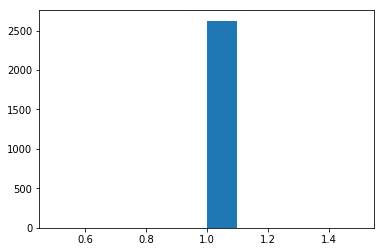

In [41]:
import matplotlib.pyplot as plt
plt.hist(submission['time_to_failure'])


In [42]:
submission.to_csv('l.csv',index = False)

In [43]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='l.csv')

In [44]:
from IPython.display import HTML
html = '<a href = "l.csv">d</a>'
HTML(html)

In [ ]:
def testInfo(seg_id):
    test_df = pd.read_csv('../input/test/' + seg_id + '.csv')
    return(test_df.acoustic_data.max())
#submission = pd.read_csv('../input/sample_submission.csv')
#submission['time_to_failure']=submission['seg_id'].apply(testInfo)